Train: .\adult.data.csv
Test : .\adult.test.csv
train: (32561, 14), test: (16281, 14), classes: ['<=50K', '>50K']
best ccp_alpha = 0.00011060779210515352

=== 網格搜尋前幾名（依葉數小→大、同葉數看準確率）===
    max_depth  max_leaf_nodes    cv_acc    cv_std  actual_depth  leaf_count  \
0           3              16  0.843770  0.001614             3           8   
1           3              32  0.843770  0.001614             3           8   
2           3              64  0.843770  0.001614             3           8   
3           3             128  0.843770  0.001614             3           8   
4           3             256  0.843770  0.001614             3           8   
5           3             512  0.843770  0.001614             3           8   
6           4              16  0.845459  0.000891             4          13   
7           4              32  0.845459  0.000891             4          13   
8           4              64  0.845459  0.000891             4          13   
9           4           

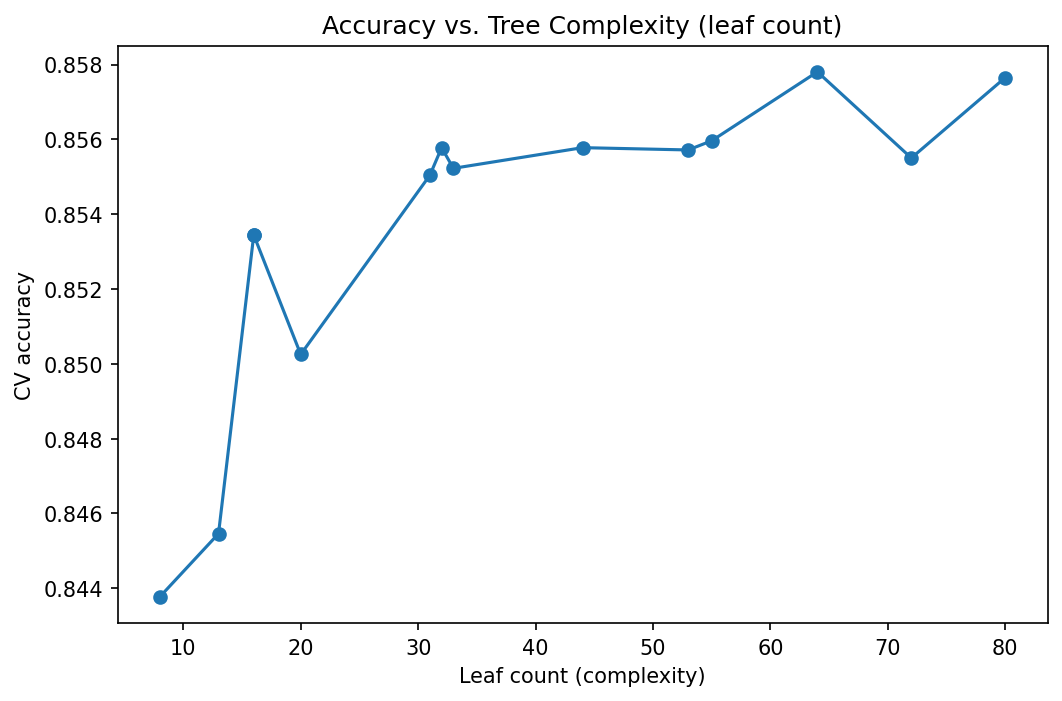

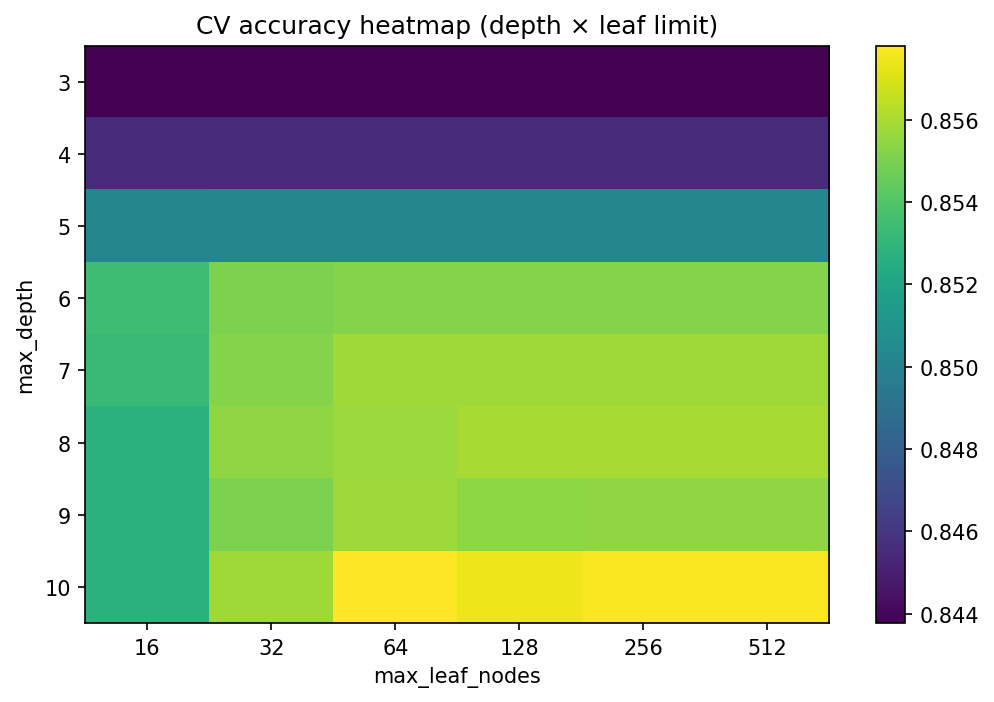

=== 依 CV 準確率由高到低 ===
 max_depth  max_leaf_nodes   cv_acc   cv_std  actual_depth  leaf_count  node_count
        10              64 0.857805 0.001068            10          64         127
        10             256 0.857652 0.000464            10          80         159
        10             512 0.857652 0.000464            10          80         159
        10             128 0.857468 0.000457            10          80         159
         8             128 0.855963 0.000763             8          55         109
         8             256 0.855963 0.000763             8          55         109
         8             512 0.855963 0.000763             8          55         109
        10              32 0.855778 0.000638            10          32          63
         7              64 0.855778 0.001014             7          44          87
         7             128 0.855778 0.001014             7          44          87
         7             256 0.855778 0.001014             7        

In [7]:
# -*- coding: utf-8 -*-
# Grid search: max_depth ∈ {3..10}, max_leaf_nodes ∈ {16,32,64,128,256,512}
# → 畫 準確率 vs 複雜度(葉數) 曲線 → elbow 取 Small/Medium/Large 三組參數 → 在測試集評估

import os, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===================== 讀檔（自動搜尋常見檔名） =====================
TRAIN_CAND = [
    "adult_data_inputation.csv", "adult_data_imputation.csv",
    "adult_data_no_duplicates.csv", "adult.data.csv"
]
TEST_CAND  = [
    "adult_test_no_duplicates.csv", "adult.test.csv"
]

def find_file(cands):
    cset = {c.lower() for c in cands}
    for root, _, files in os.walk(".", topdown=True):
        for f in files:
            if f.lower() in cset:
                return os.path.join(root, f)
    return None

TRAIN_PATH = find_file(TRAIN_CAND)
TEST_PATH  = find_file(TEST_CAND)
assert TRAIN_PATH is not None, "找不到訓練檔 (adult_data_inputation.csv / adult.data.csv ...)"
assert TEST_PATH  is not None, "找不到測試檔 (adult_test_no_duplicates.csv / adult.test.csv ...)"
print("Train:", TRAIN_PATH)
print("Test :", TEST_PATH)

TARGET_COL  = "class"
RANDOM_SEED = 42
NA_VALUES = ["", " ", "  ", "\t", "\n", "?", "NA", "N/A", "na", "null", "None", "\\N"]

train = pd.read_csv(TRAIN_PATH, dtype=str, keep_default_na=True, na_values=NA_VALUES, encoding_errors="ignore")
test  = pd.read_csv(TEST_PATH,  dtype=str, keep_default_na=True, na_values=NA_VALUES, encoding_errors="ignore", comment="|")
if "calss" in test.columns and "class" not in test.columns:
    test = test.rename(columns={"calss": "class"})

assert TARGET_COL in train.columns, f"訓練檔缺少標籤欄 {TARGET_COL}"
assert TARGET_COL in test.columns,  f"測試檔缺少標籤欄 {TARGET_COL}"

# 去除 *_imputed_flag（若有）
flag_cols = [c for c in train.columns if c.endswith("_imputed_flag")]
train = train.drop(columns=flag_cols, errors="ignore")
test  = test.drop(columns=flag_cols, errors="ignore")

def split_xy(df):
    y = df[TARGET_COL].astype(str).str.strip().str.replace(".", "", regex=False)
    X = df.drop(columns=[TARGET_COL])
    return X, y

X_train, y_train = split_xy(train)
X_test,  y_test  = split_xy(test)
print(f"train: {X_train.shape}, test: {X_test.shape}, classes: {sorted(y_train.unique())}")

# ===================== 前處理（相容新舊 sklearn 的 OHE 參數） =====================
num_cands = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
num_cols = [c for c in num_cands if c in X_train.columns]
cat_cols = [c for c in X_train.columns if c not in num_cols]

def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.4
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)         # 舊版

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh",  make_ohe())]), cat_cols),
])

# ===================== 先用訓練集找「最佳 ccp_alpha」（後修剪強度） =====================
pre_fitted = pre.fit(X_train, y_train)
Xtr = pre_fitted.transform(X_train)
path = DecisionTreeClassifier(criterion="gini", random_state=RANDOM_SEED).cost_complexity_pruning_path(Xtr, y_train)
ccp_alphas = np.unique(path.ccp_alphas)
if len(ccp_alphas) > 12:
    ccp_alphas = np.unique(np.quantile(ccp_alphas, np.linspace(0, 1, 12)))

grid_alpha = GridSearchCV(
    Pipeline([("pre", pre), ("clf", DecisionTreeClassifier(criterion="gini", random_state=RANDOM_SEED))]),
    {"clf__ccp_alpha": ccp_alphas},
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=1, refit=True, verbose=0
)
grid_alpha.fit(X_train, y_train)
best_alpha = float(grid_alpha.best_params_["clf__ccp_alpha"])
print("best ccp_alpha =", best_alpha)

# ===================== 小型網格搜尋（深度 × 葉數上限） =====================
depth_list = list(range(3, 11))  # 3..10
leaf_list  = [16, 32, 64, 128, 256, 512]

results = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

for md in depth_list:
    for mln in leaf_list:
        pipe = Pipeline([
            ("pre", pre),
            ("clf", DecisionTreeClassifier(
                criterion="gini",
                random_state=RANDOM_SEED,
                ccp_alpha=best_alpha,
                max_depth=md,
                max_leaf_nodes=mln
            )),
        ])
        # 3 折 CV 準確率
        scores = cross_val_score(pipe, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=1)
        cv_mean = float(scores.mean())
        cv_std  = float(scores.std())

        # 為了記錄實際樹大小，再在整個訓練集 fit 一次（不影響 CV）
        pipe.fit(X_train, y_train)
        clf = pipe.named_steps["clf"]
        results.append({
            "max_depth": md,
            "max_leaf_nodes": mln,
            "cv_acc": cv_mean,
            "cv_std": cv_std,
            "actual_depth": int(clf.get_depth()),
            "leaf_count": int(clf.get_n_leaves()),
            "node_count": int(clf.tree_.node_count),
        })

res = pd.DataFrame(results).sort_values(["leaf_count","cv_acc"], ascending=[True, False]).reset_index(drop=True)
print("\n=== 網格搜尋前幾名（依葉數小→大、同葉數看準確率）===")
print(res.head(50))

# ===================== 準確率 vs 複雜度（葉數）曲線 + elbow =====================
# 以「相同 leaf_count 時取最佳 cv_acc」來畫（避免同一葉數有多組參數）
best_per_leaf = res.groupby("leaf_count", as_index=False)["cv_acc"].max().sort_values("leaf_count")
xs = best_per_leaf["leaf_count"].to_numpy()
ys = best_per_leaf["cv_acc"].to_numpy()

# elbow（最大距離法）：找距離「連線(第一點→最後一點)」最遠的點
def elbow_index(x, y):
    if len(x) <= 2:
        return 0
    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-9)
    y_norm = (y - y.min()) / (y.max() - y.min() + 1e-9)
    x1, y1 = x_norm[0], y_norm[0]
    x2, y2 = x_norm[-1], y_norm[-1]
    # 距離：| (y2 - y1)*x - (x2 - x1)*y + x2*y1 - y2*x1 | / sqrt((y2 - y1)^2 + (x2 - x1)^2)
    denom = np.sqrt((y2 - y1)**2 + (x2 - x1)**2) + 1e-12
    d = np.abs((y2 - y1)*x_norm - (x2 - x1)*y_norm + (x2*y1 - y2*x1)) / denom
    return int(np.argmax(d))

knee_i = elbow_index(xs, ys)
knee_leaf = int(xs[knee_i])
knee_acc  = float(ys[knee_i])

# 依據 elbow 定義 Small/Medium/Large
def pick_row_by_leaf_range(df, lo, hi):
    cand = df[(df["leaf_count"] >= lo) & (df["leaf_count"] <= hi)]
    if cand.empty:
        # 找最近的
        idx = (df["leaf_count"] - (lo+hi)/2.0).abs().idxmin()
        return df.loc[idx]
    return cand.sort_values("cv_acc", ascending=False).iloc[0]

small = pick_row_by_leaf_range(res, lo=xs.min(), hi=max(xs.min(), int(knee_leaf*0.6)))
medium = res[res["leaf_count"] == knee_leaf].sort_values("cv_acc", ascending=False).iloc[0]
large  = pick_row_by_leaf_range(res, lo=max(knee_leaf+1, int(knee_leaf*1.2)), hi=xs.max())

print("\n=== 推薦三組（依 elbow）===")
for name, row in [("Small", small), ("Medium (knee)", medium), ("Large", large)]:
    print(f"{name}: depth={row.max_depth}, leaves_limit={row.max_leaf_nodes} | "
          f"actual_depth={row.actual_depth}, leaf_count={row.leaf_count} | "
          f"cv_acc={row.cv_acc:.4f}")

# 1) 畫 準確率 vs 葉數（單一圖）
plt.figure(figsize=(8,5))
plt.plot(xs, ys, marker="o")
plt.scatter([knee_leaf], [knee_acc])  # 標出拐點
plt.xlabel("Leaf count (complexity)")
plt.ylabel("CV accuracy")
plt.title("Accuracy vs. Tree Complexity (leaf count)")
plt.show()

# 2) （可選）熱圖：深度×葉上限 的 CV 準確率（單一圖）
pivot = res.pivot_table(index="max_depth", columns="max_leaf_nodes", values="cv_acc", aggfunc="max")
plt.figure(figsize=(8,5))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=0)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("max_leaf_nodes"); plt.ylabel("max_depth")
plt.title("CV accuracy heatmap (depth × leaf limit)")
plt.colorbar()
plt.show()

# 準確率由高到低（同分時優先葉數少、深度淺，方便解釋）
ranked = (
    res.sort_values(["cv_acc", "leaf_count", "actual_depth"],
                    ascending=[False, True, True])
          .reset_index(drop=True)
)
print("=== 依 CV 準確率由高到低 ===")
print(ranked.head(20).to_string(index=False))   # 看前 20 名
# 若要全表：
# print(ranked.to_string(index=False))

# 若想存檔：
# ranked.to_csv("grid_ranked_by_cvacc.csv", index=False, encoding="utf-8-sig")

# ===================== 以三組「推薦參數」在測試集評估 =====================
def train_eval(md, mln):
    pipe = Pipeline([
        ("pre", pre),
        ("clf", DecisionTreeClassifier(
            criterion="gini", random_state=RANDOM_SEED,
            ccp_alpha=best_alpha, max_depth=md, max_leaf_nodes=mln
        ))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    clf = pipe.named_steps["clf"]
    print(f"→ Test acc={acc:.4f} | depth={clf.get_depth()} leaves={clf.get_n_leaves()}")
    return acc

print("\n=== 測試集表現 ===")
print("Small :", end=" "); _ = train_eval(int(small.max_depth),  int(small.max_leaf_nodes))
print("Medium:", end=" "); _ = train_eval(int(medium.max_depth), int(medium.max_leaf_nodes))
print("Large :", end=" "); _ = train_eval(int(large.max_depth),  int(large.max_leaf_nodes))



=== 訓練 Small (max_depth=3, max_leaf_nodes=16) ===
Test acc=0.8448 | depth=3 | leaves=8


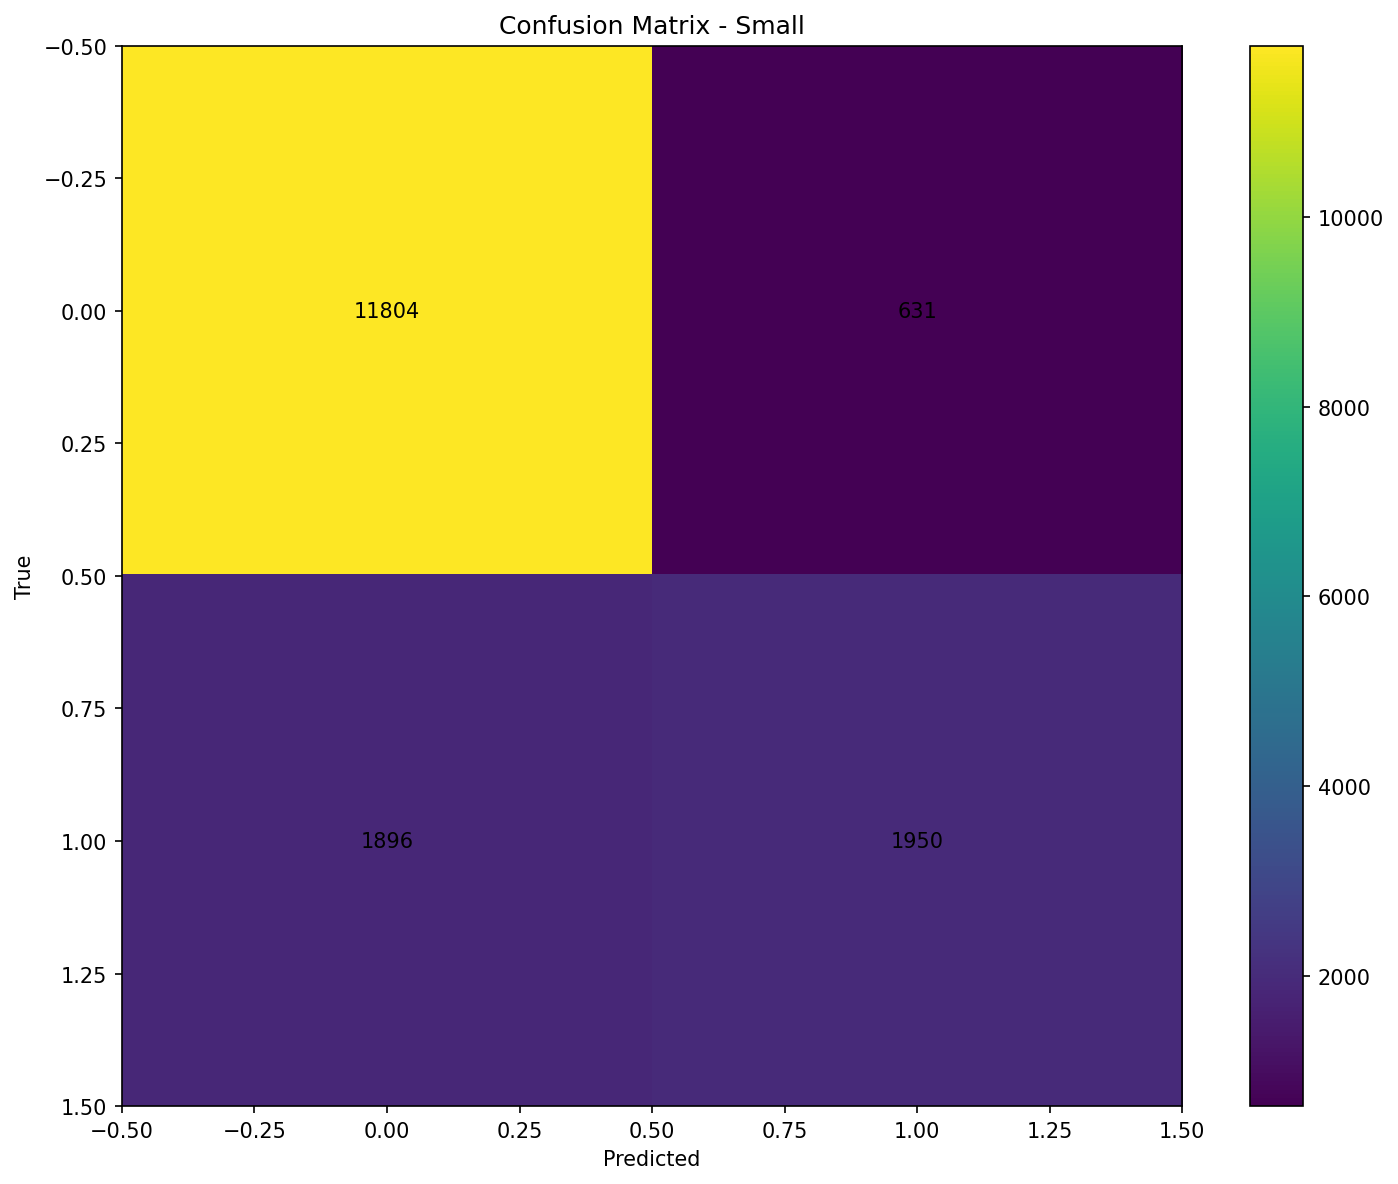

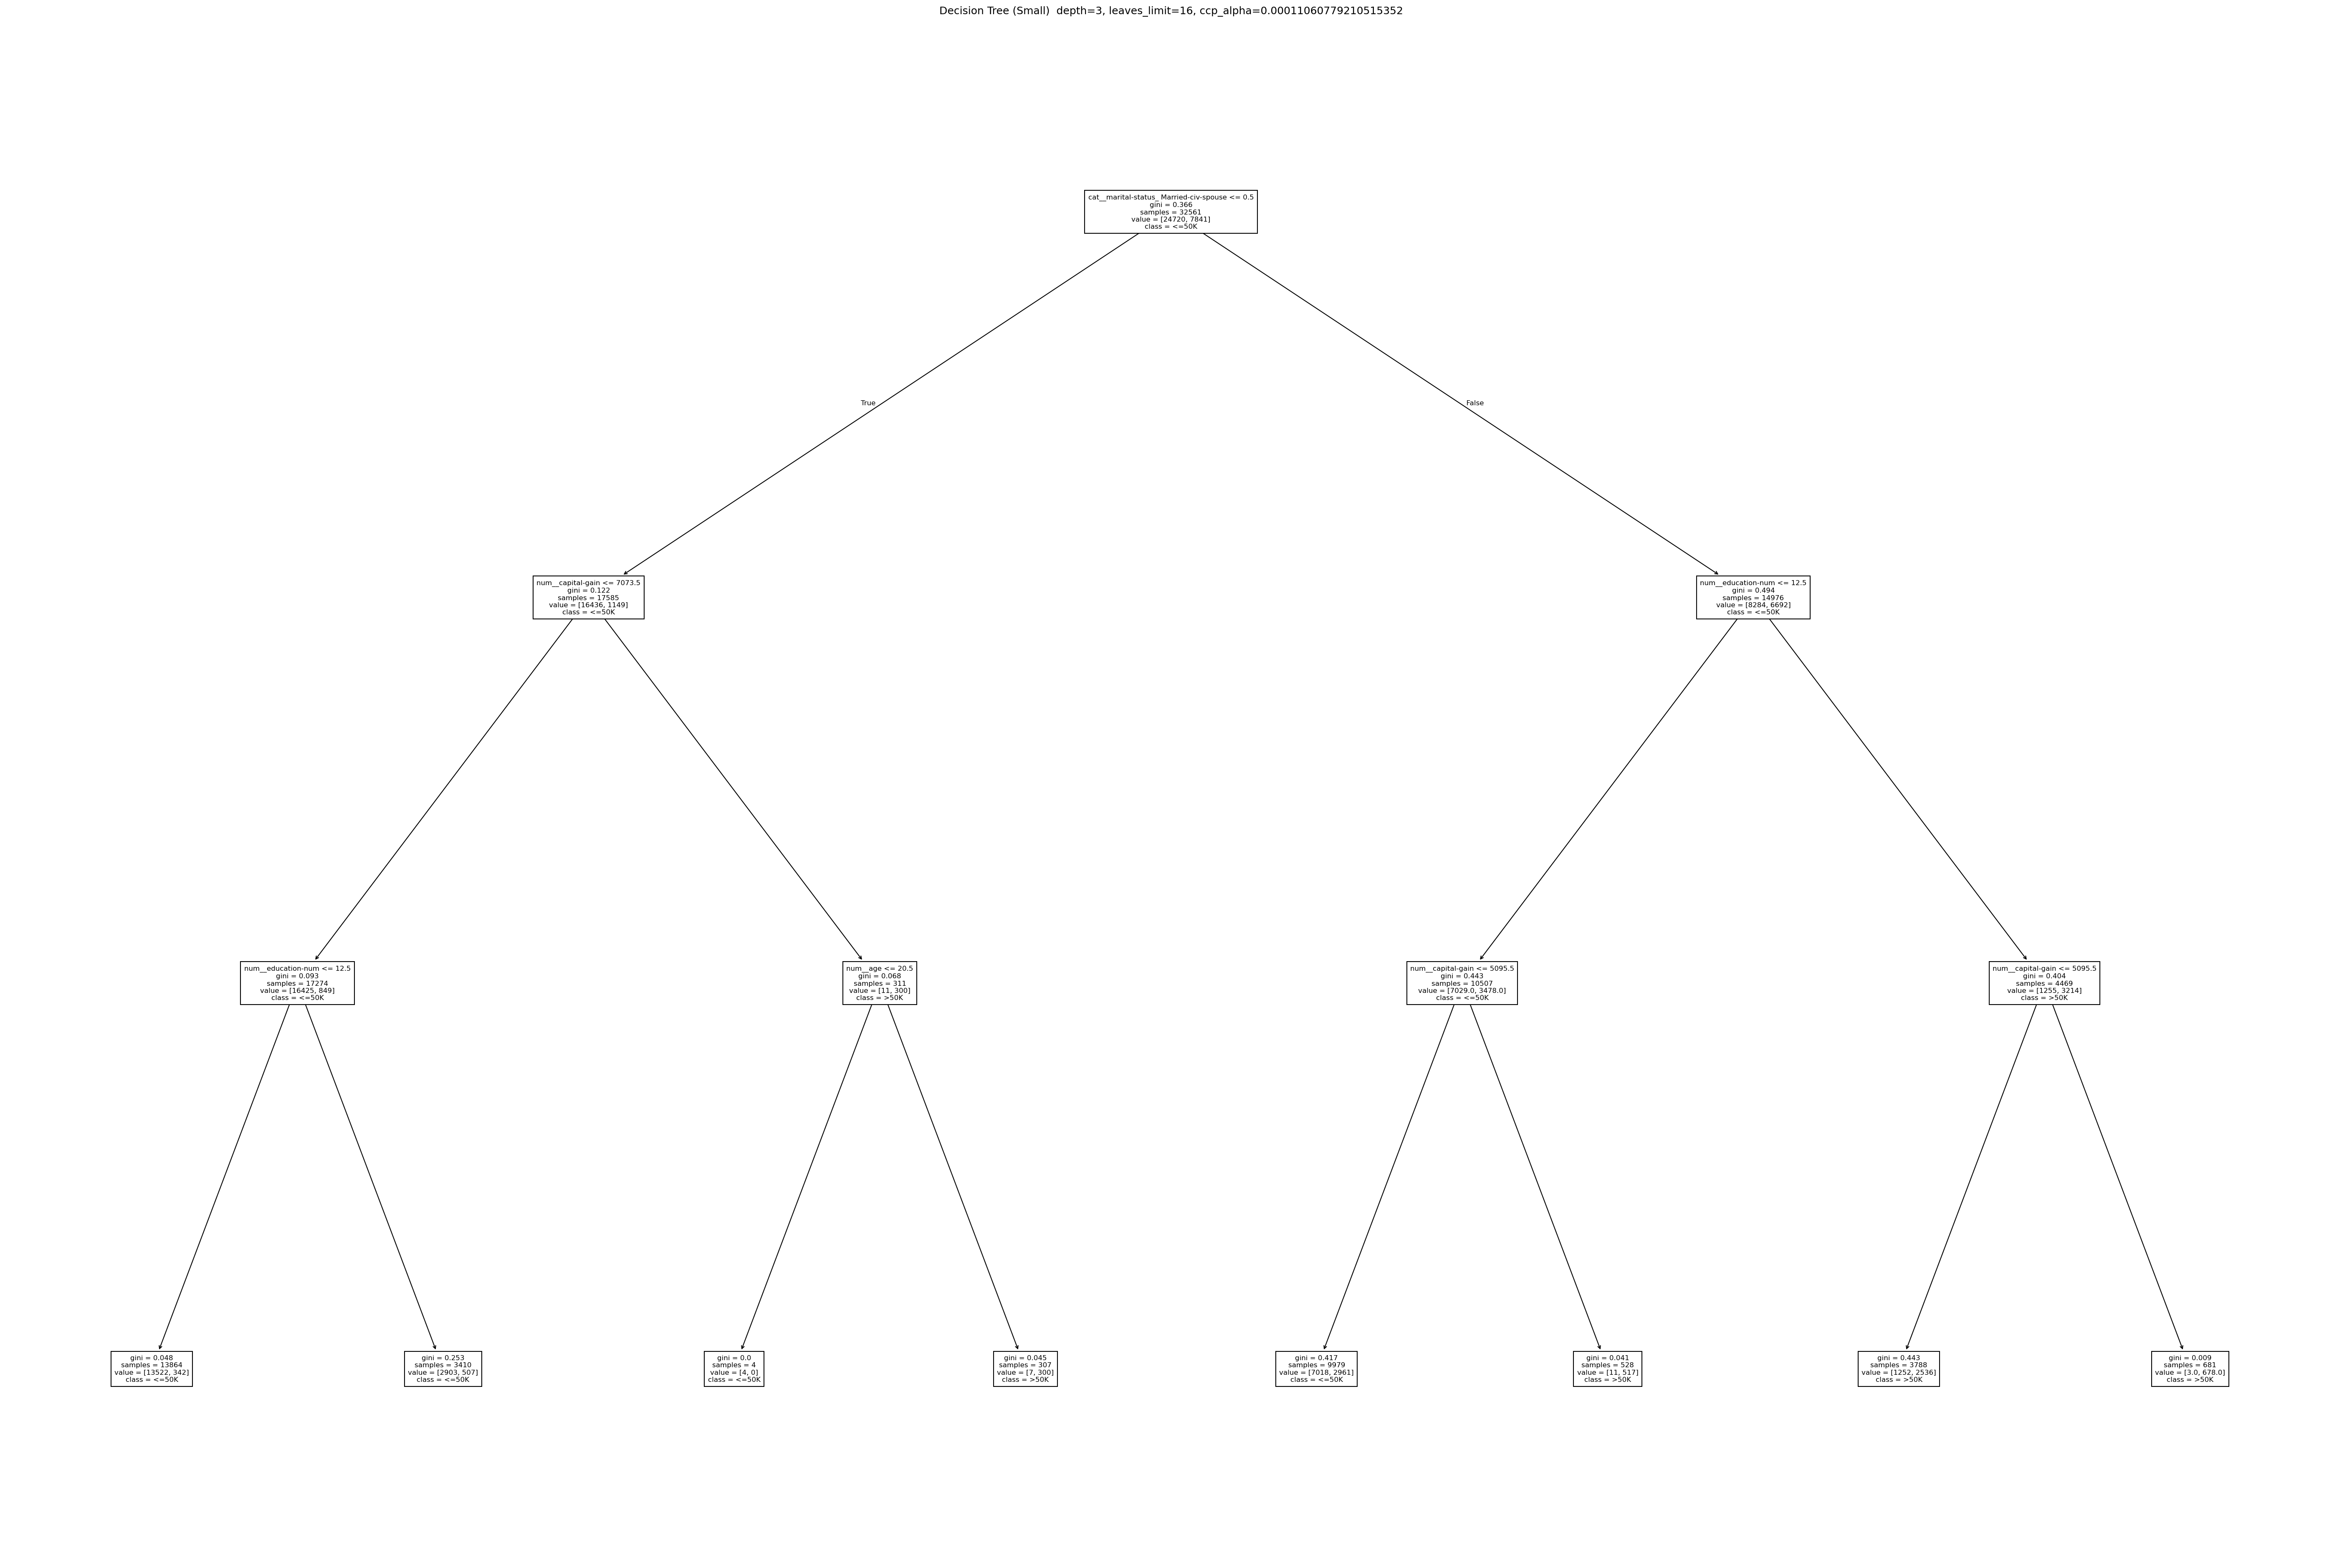


=== 訓練 Medium (max_depth=6, max_leaf_nodes=16) ===
Test acc=0.8557 | depth=6 | leaves=16


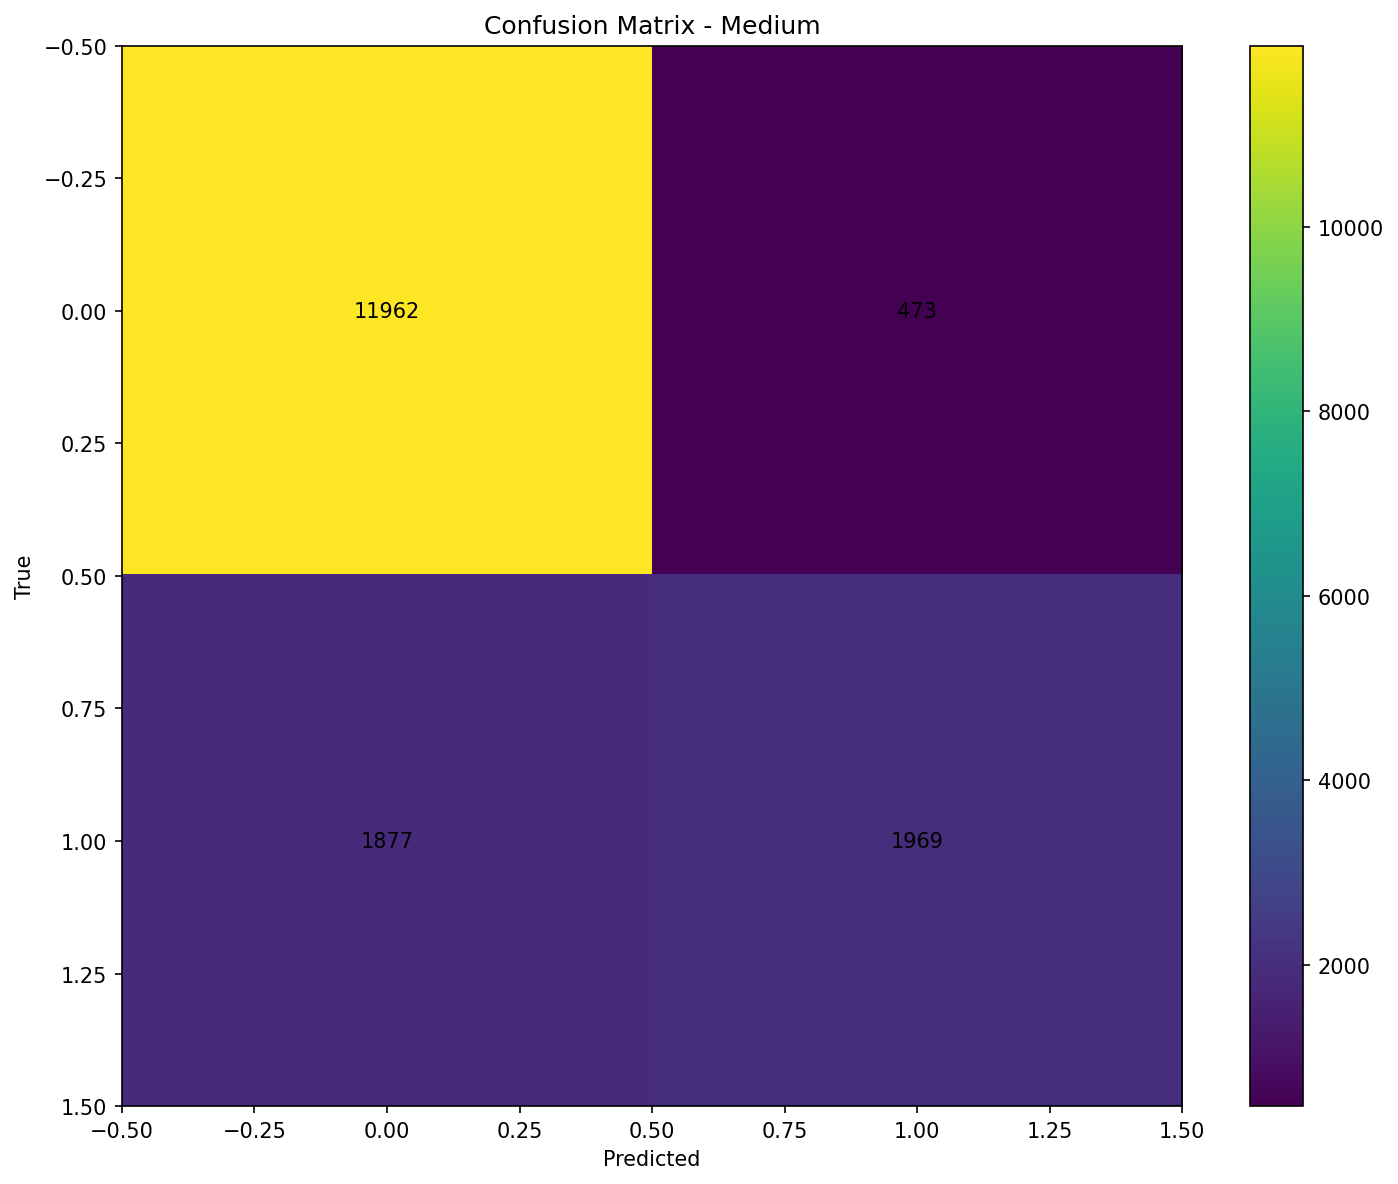

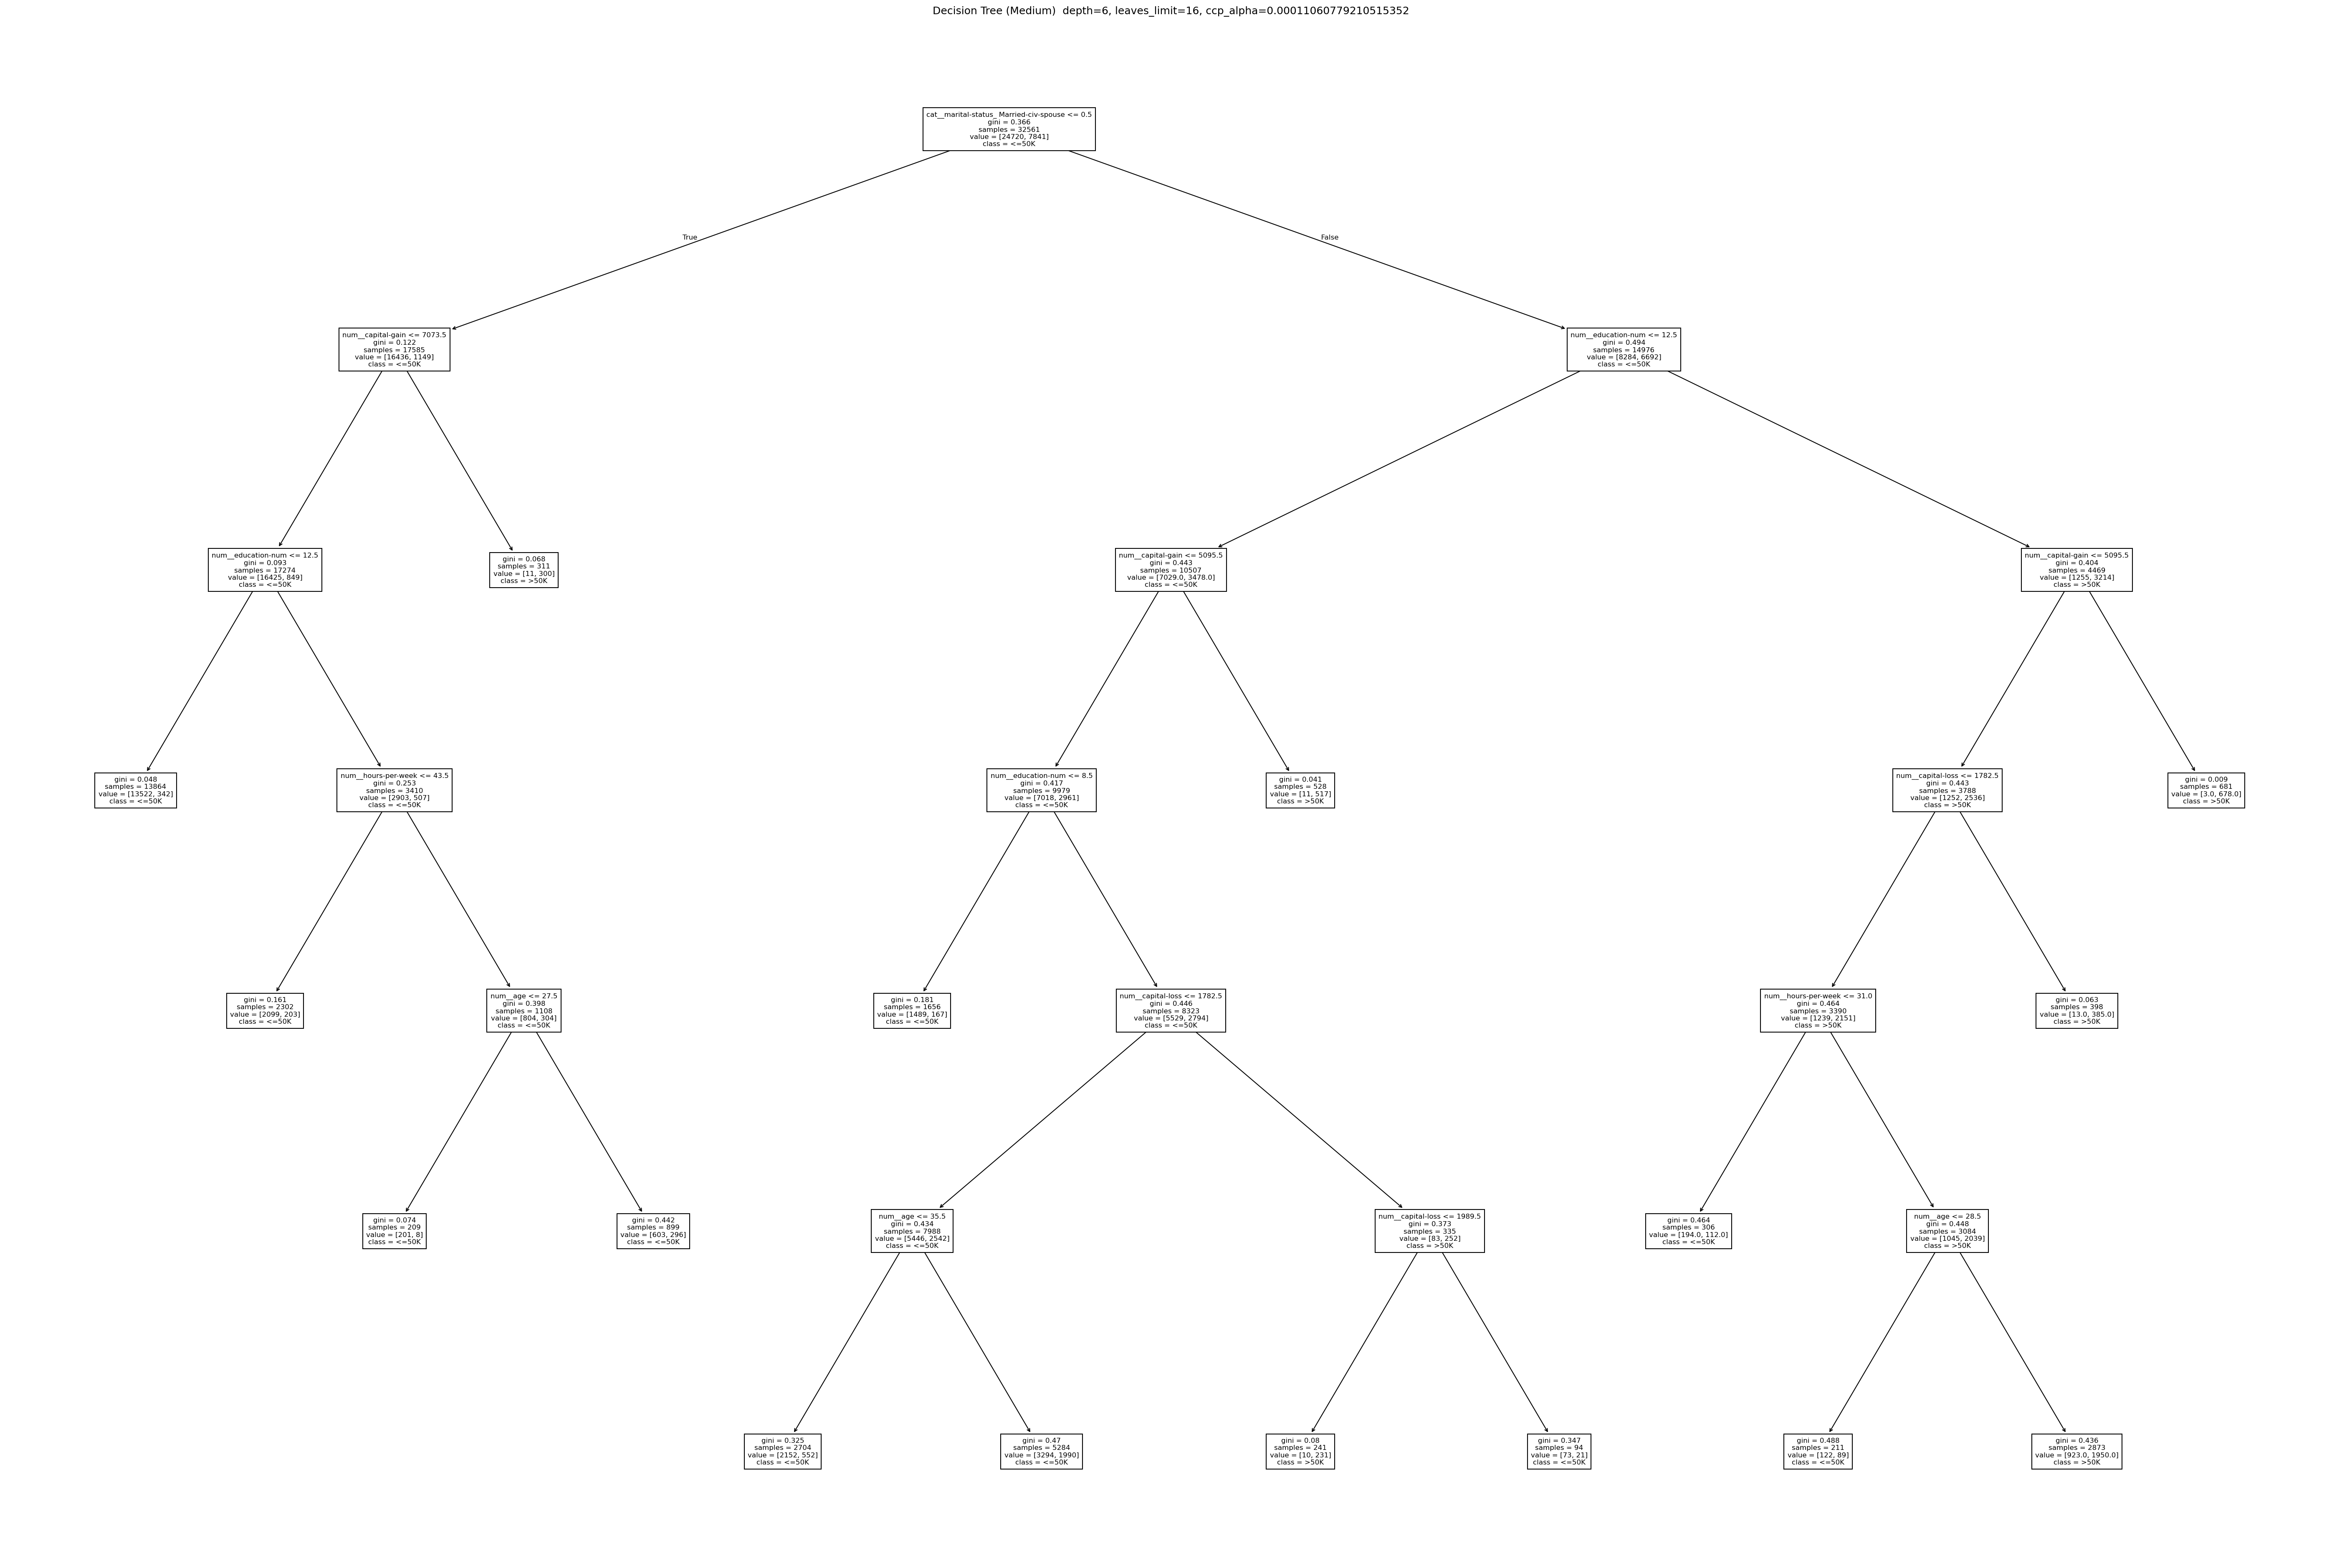


=== 訓練 Large (max_depth=10, max_leaf_nodes=64) ===
Test acc=0.8612 | depth=10 | leaves=64


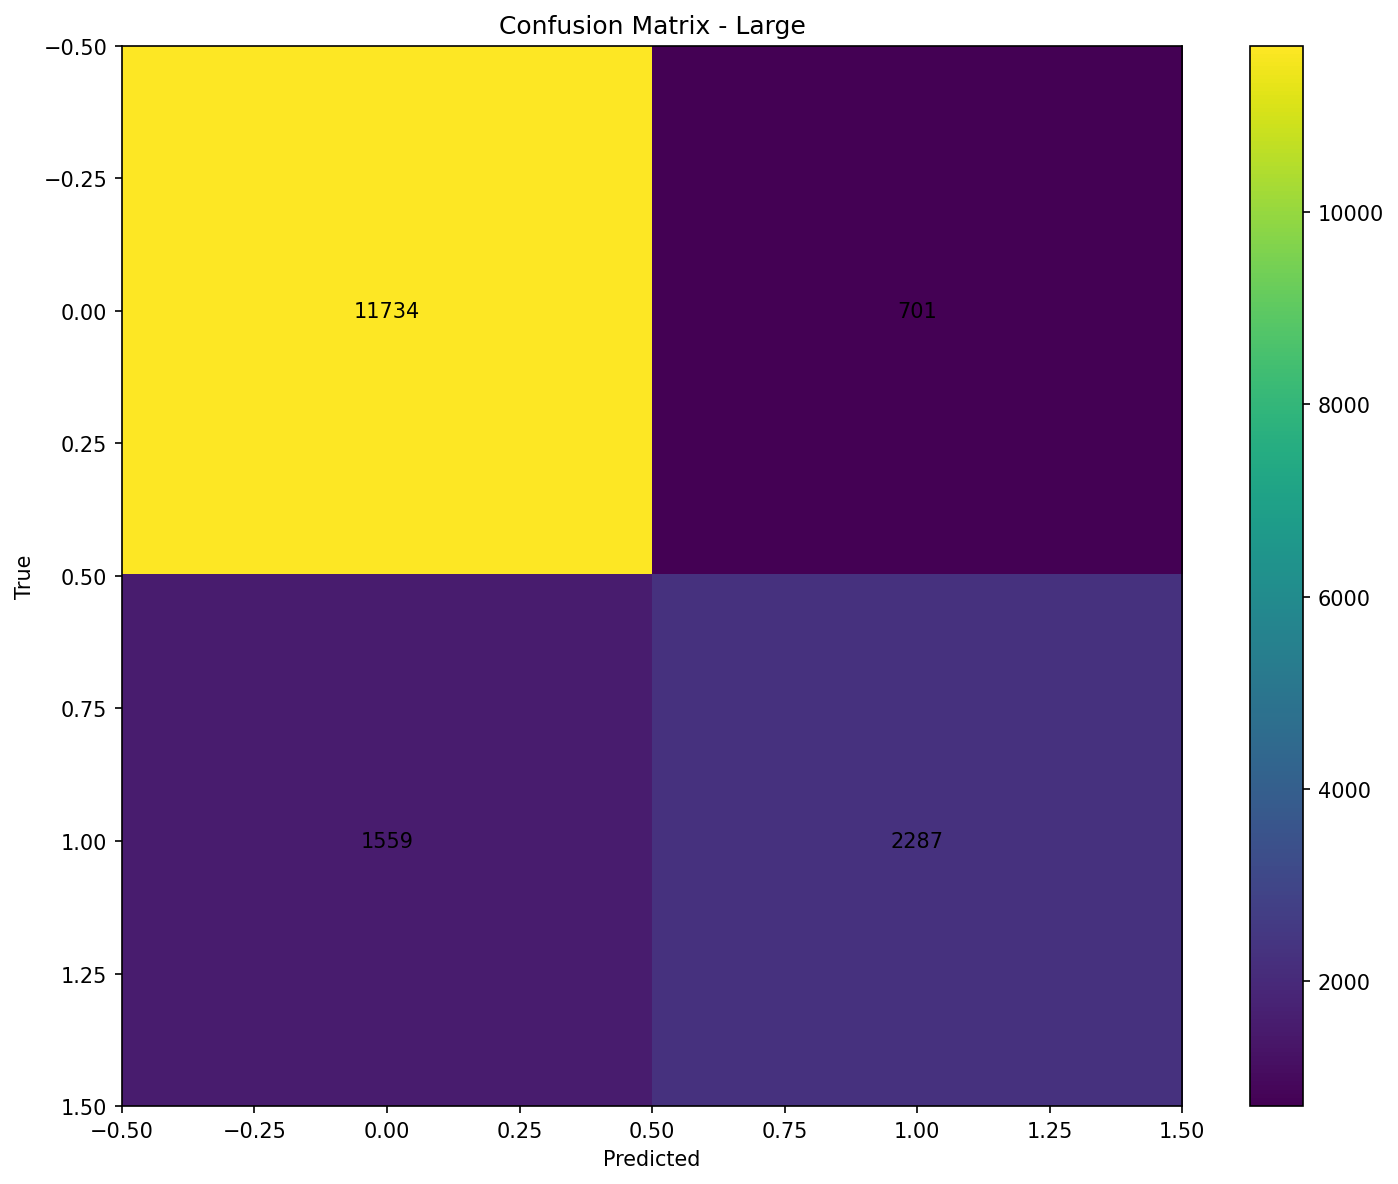

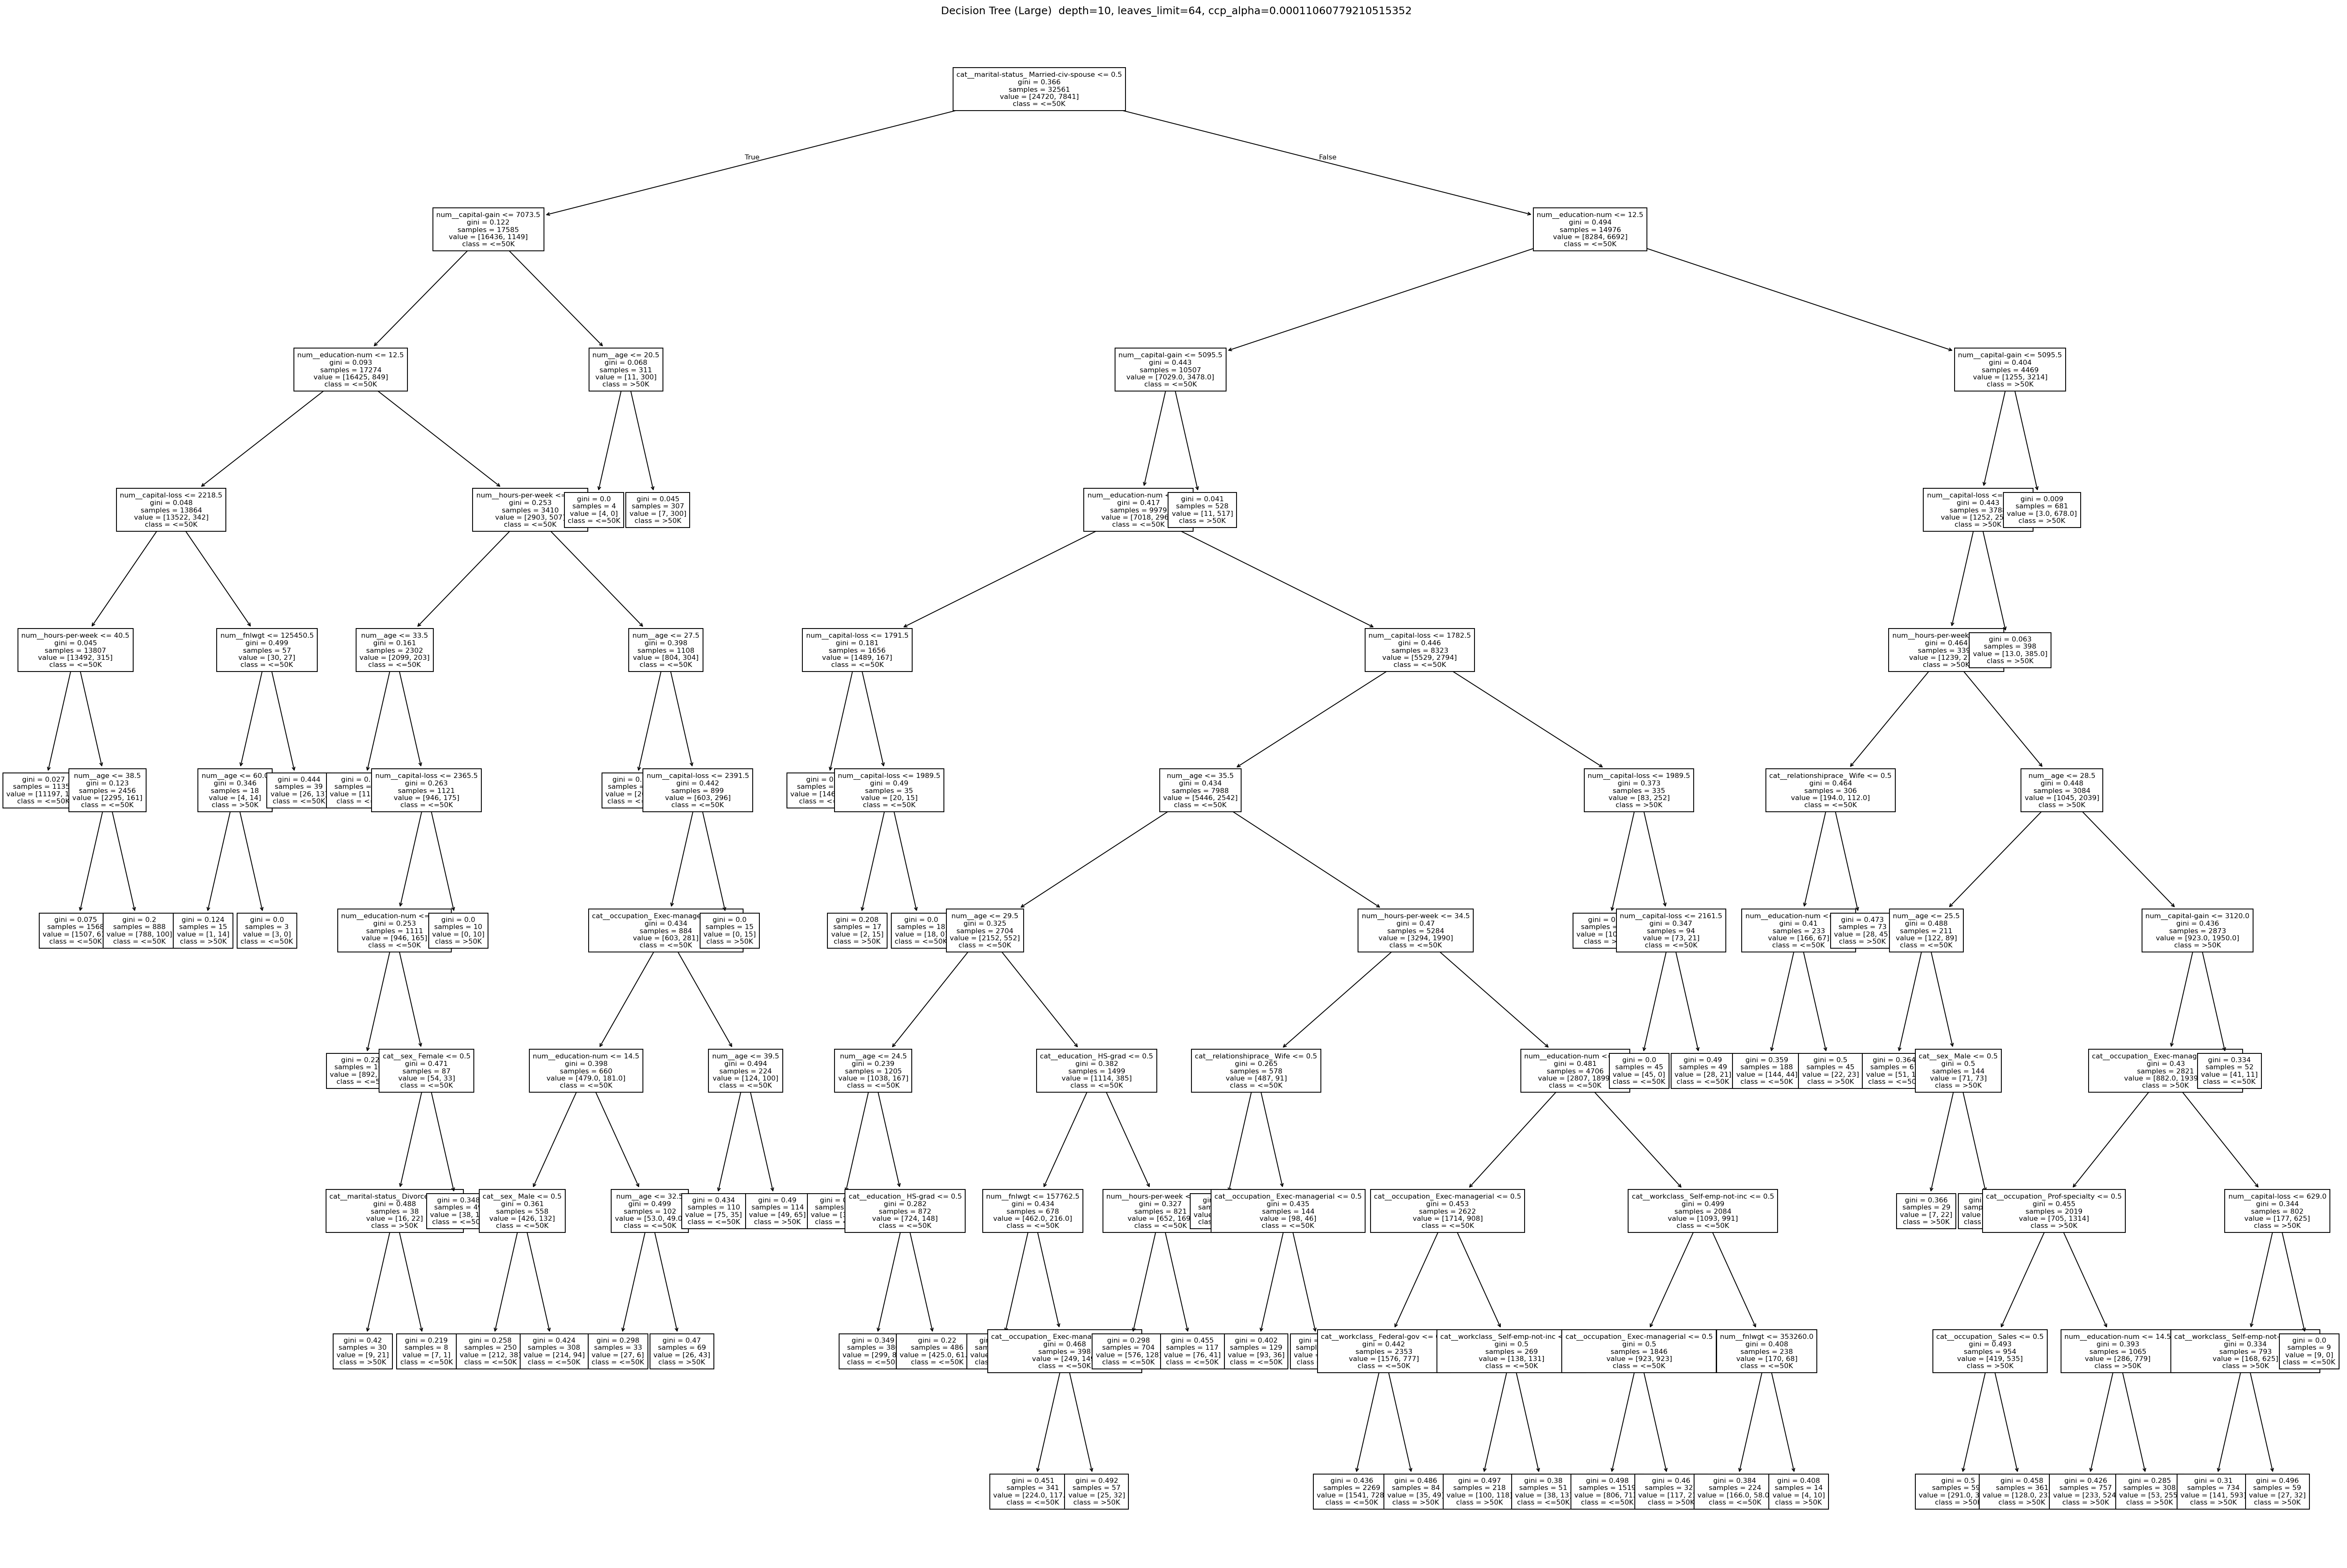


=== 三組參數測試成績 ===
  setting  max_depth  max_leaf_nodes  actual_depth  leaf_count  test_accuracy
0   Large         10              64            10          64       0.861188
1  Medium          6              16             6          16       0.855660
2   Small          3              16             3           8       0.844788

輸出完成 → C:\Users\rui0731\anaconda_projects\0e478e30-a257-4faa-aa14-a67f5fcce6cf\dt_postprune_elbow_exports
 - C:\Users\rui0731\anaconda_projects\0e478e30-a257-4faa-aa14-a67f5fcce6cf\dt_postprune_elbow_exports\Small_classification_report.txt
 - C:\Users\rui0731\anaconda_projects\0e478e30-a257-4faa-aa14-a67f5fcce6cf\dt_postprune_elbow_exports\Small_confusion_matrix.csv
 - C:\Users\rui0731\anaconda_projects\0e478e30-a257-4faa-aa14-a67f5fcce6cf\dt_postprune_elbow_exports\Small_confusion_matrix.png
 - C:\Users\rui0731\anaconda_projects\0e478e30-a257-4faa-aa14-a67f5fcce6cf\dt_postprune_elbow_exports\Small_confusion_matrix.svg
 - C:\Users\rui0731\anaconda_projects\0e47

In [5]:
# 後續評估與高解析輸出（接續 elbow 結果用）
import os, io, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === 圖像輸出參數 ===
OUT_DIR       = "./dt_postprune_elbow_exports"
SAVE_DPI      = 600           # PNG 解析度
TREE_FIGSIZE  = (48, 32)      # 樹圖畫布大小（英吋）
CM_FIGSIZE    = (10, 8)       # 混淆矩陣畫布大小
TREE_FONTSIZE = 8             # 樹節點文字大小
mpl.rcParams["figure.dpi"] = 150
os.makedirs(OUT_DIR, exist_ok=True)

# === 取得 one-hot 後的特徵名稱 ===
def feature_names_from(pipe, cat_cols, num_cols):
    preproc = pipe.named_steps["pre"]
    try:
        return preproc.get_feature_names_out()
    except Exception:
        cat_ohe = preproc.transformers_[1][1].named_steps["oh"]
        cat_names = cat_ohe.get_feature_names_out(cat_cols)
        return np.array(list(num_cols) + list(cat_names))

# 你前面用到的數值/類別欄位（跟上一段保持一致）
num_cands = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
num_cols  = [c for c in num_cands if c in X_train.columns]
cat_cols  = [c for c in X_train.columns if c not in num_cols]

# === 用 elbow 推薦的三組參數 ===
selected = [
    {"name": "Small",  "max_depth": int(small.max_depth),  "max_leaf_nodes": int(small.max_leaf_nodes)},
    {"name": "Medium", "max_depth": int(medium.max_depth), "max_leaf_nodes": int(medium.max_leaf_nodes)},
    {"name": "Large",  "max_depth": int(large.max_depth),  "max_leaf_nodes": int(large.max_leaf_nodes)},
]

rows, artifacts = [], []

for p in selected:
    name, md, mln = p["name"], p["max_depth"], p["max_leaf_nodes"]
    print(f"\n=== 訓練 {name} (max_depth={md}, max_leaf_nodes={mln}) ===")

    pipe = Pipeline([
        ("pre", pre),  # ← 前處理只在訓練集 fit 過，這裡 pipeline 會自動處理
        ("clf", DecisionTreeClassifier(
            criterion="gini", random_state=42,
            ccp_alpha=best_alpha, max_depth=md, max_leaf_nodes=mln
        )),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    clf = pipe.named_steps["clf"]
    print(f"Test acc={acc:.4f} | depth={clf.get_depth()} | leaves={clf.get_n_leaves()}")

    # === classification report（TXT）
    rep_txt = classification_report(y_test, y_pred, digits=4)
    rep_path = os.path.join(OUT_DIR, f"{name}_classification_report.txt")
    with open(rep_path, "w", encoding="utf-8") as f:
        f.write(rep_txt)
    artifacts.append(rep_path)

    # === 混淆矩陣（CSV + 高 DPI PNG + SVG）
    labels = np.unique(y_train)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_csv = os.path.join(OUT_DIR, f"{name}_confusion_matrix.csv")
    cm_df.to_csv(cm_csv, encoding="utf-8-sig"); artifacts.append(cm_csv)

    fig_cm, ax = plt.subplots(figsize=CM_FIGSIZE)
    im = ax.imshow(cm)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    fig_cm.colorbar(im, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")
    cm_png = os.path.join(OUT_DIR, f"{name}_confusion_matrix.png")
    cm_svg = os.path.join(OUT_DIR, f"{name}_confusion_matrix.svg")
    fig_cm.tight_layout()
    fig_cm.savefig(cm_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig_cm.savefig(cm_svg, bbox_inches="tight")
    plt.show(); plt.close(fig_cm)
    artifacts += [cm_png, cm_svg]

    # === 決策樹（高 DPI PNG + SVG/PDF 向量）
    feat_names_arr = feature_names_from(pipe, cat_cols, num_cols)
    fig_tree = plt.figure(figsize=TREE_FIGSIZE)
    plot_tree(
        clf,
        feature_names=feat_names_arr,
        class_names=labels,
        filled=False,
        max_depth=md,
        fontsize=TREE_FONTSIZE
    )
    plt.title(f"Decision Tree ({name})  depth={md}, leaves_limit={mln}, ccp_alpha={best_alpha}")

    tree_png = os.path.join(OUT_DIR, f"{name}_tree_d{md}_l{mln}.png")
    tree_svg = os.path.join(OUT_DIR, f"{name}_tree_d{md}_l{mln}.svg")
    tree_pdf = os.path.join(OUT_DIR, f"{name}_tree_d{md}_l{mln}.pdf")
    fig_tree.savefig(tree_png, dpi=SAVE_DPI, bbox_inches="tight", pad_inches=0.1)
    fig_tree.savefig(tree_svg, bbox_inches="tight")
    fig_tree.savefig(tree_pdf, bbox_inches="tight")
    plt.show(); plt.close(fig_tree)
    artifacts += [tree_png, tree_svg, tree_pdf]

    rows.append({
        "setting": name,
        "max_depth": md, "max_leaf_nodes": mln,
        "actual_depth": clf.get_depth(), "leaf_count": clf.get_n_leaves(),
        "test_accuracy": acc
    })

# === 總表 + HTML + ZIP
summary = pd.DataFrame(rows).sort_values("test_accuracy", ascending=False).reset_index(drop=True)
print("\n=== 三組參數測試成績 ===")
print(summary)

summary_csv = os.path.join(OUT_DIR, "summary.csv")
summary.to_csv(summary_csv, index=False, encoding="utf-8-sig")
artifacts.append(summary_csv)

html = io.StringIO()
html.write("<html><head><meta charset='utf-8'><title>DT Post-pruning (elbow)</title></head><body>")
html.write("<h1>Post-pruned CART — Selected by Elbow</h1>")
html.write(summary.to_html(index=False))
for r in rows:
    name = r["setting"]
    html.write(f"<h2>{name}</h2>")
    html.write(f"<img src='{name}_confusion_matrix.png' width='480'><br/>")
    html.write(f"<img src='{name}_tree_d{r['max_depth']}_l{r['max_leaf_nodes']}.png' width='960'><br/>")
html_path = os.path.join(OUT_DIR, "report.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html.getvalue())
artifacts.append(html_path)

zip_path = os.path.join(OUT_DIR, "dt_postprune_elbow_exports.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in artifacts:
        z.write(p, arcname=os.path.basename(p))

print("\n輸出完成 →", os.path.abspath(OUT_DIR))
for p in artifacts + [zip_path]:
    print(" -", os.path.abspath(p))